### Motivation and equations
js (jserences@ucsd.edu) for CSHL 2024

For a great overview/tutorial paper see [Song et al. 2016](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004792)

A neurons firing rate is a function of its inputs from upstream areas as well as connections (both excitatory and inhibitory) from neighboring neurons. In continuous rate RNNs, we assess this "firing rate" as a continuous number, with a higher value corresponing to a higher probabiliy of a spike (but no spiking happens per se). 

In a RNN with $N$ units in the hidden layer, there are $N_{in}$ timevarying inputs $u(t)$ and $N_{out}$ outputs $z(t)$. The inputs $u$ reflect a timeseries of stimulus values that are evaluated at each of $T$ timesteps, and the outputs represent the decision variable (here a another timeseries of length $T$). For example, if you had 250 timepoints and two input stimuli, then $u$ would be a [250,2] matrix. Similarly, if you had two outputs, then $z$ would be a [250,2] matrix. 

The firing rate of units in the hidden layer are related to input currents $x(t)$ by a non-linear activation function $f(\phi)$ that rectifies the input currents (e.g. max(x,0), or rectified linear unit "relu") and that sometimes imposes an upper bound (e.g. a sigmoid). This process in simple form is described by:

(1) $\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^NW^{hid}_{ij}r_{j} + \sum_{k=1}^{N_{in}}W^{in}_{ik}u_{k} + \epsilon_{i}$

where $k$ = 1...$N_{in}$

(2) $r_{i}$ = $f(x_{i})$  

and the output is:

(3) $z_{\ell} = \sum_{i=1}^NW_{\ell i}^{out}r_i$

where $\ell$ = 1...$N_{out}$

These continuous time dynamics can then be discretized in timesteps of $\Delta t$ (after some rearranging and letting $\alpha = \frac{\Delta t}{\tau}$):

(4) $x_{t} = (1-\alpha)x_{t-1} + \alpha(W^{hid}r_{t-1} + W^{in}u_{t}) + \epsilon$

(5) $r_t$ = $f(x_{t})$

and the outputs are computed by: 

(6) $z_t = W^{out}r_t$

In equation 4, $(1-\alpha)x_{t-1}$ is the activation state at the *last timestep*, $\alpha(W^{hid}r_{t-1} + W^{in}u_{t})$ is the weighted influence of hidden layer units on each other at the *last timestep* plus the weighted stimulus input at the *current timestep*. $\alpha$ controls the relative impact of past and present states.     

As we'll see there are more parameters that are part of this (e.g. bias terms, noise injected at different stages, etc) and in the more advanced tutorial we can see how to further control the proportion of connected units in the hidden layer, the sign of these connections (i.e. make exc and inh units) so that we can build more interesting networks that have biologically relevant properties.


### Imports

In [2]:
# minimal imports - can import sub modules to make code cleaner, but
# keeping this simple for now
import numpy as np
import matplotlib.pyplot as plt
import torch

# import class to make model inputs (defines different tasks, and can add other tasks easily using this framework)
from tasks import ctTASKS

# load the autoreload extension - don't need for tutorial but good if you ever modify the classes used in the tutorial 
# autoreload will update if you make changes to the ctTASKS class
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define model...first define the recurrent structure in RLayer (recurrent layer) class, then define full model in ctRNN (with input/output)

In [3]:
#--------------------------------
# class to define the recurrent layer object
# this specifies interactions between input
# layer and the hiden layer, as well as interactions
# between units in the hidden layer
#--------------------------------
class RLayer(torch.nn.Module):

    def __init__(self, rnn_settings):
        '''
        Initialize the params for the network
            INPUT
                rnn_settings: dict with network parameters
        '''
        # init...
        super().__init__()

        # get input params for network
        self.h_size = rnn_settings.get('h_size',32)                # size of hidden layer
        self.inp_size = rnn_settings.get('inp_size',1)             # number of inputs, last dim of a [time x batch size x num_inputs] matrix (where batch size == n_trials) 
        self.out_size = rnn_settings.get('out_size',self.inp_size) # output size - defaults to inp_size
        self.dt = rnn_settings.get('dt',1)                         # timestep
        self.tau = rnn_settings.get('tau',20)                      # decay
        self.alpha = self.dt/self.tau                              # determines the influence of prior activation on current activation
        act_func = rnn_settings.get('act_func','relu')             # activation function relating x_t to r_t
        if act_func == 'relu':
            self.act_func = torch.relu
        elif act_func == 'sigmoid':
            self.act_func = torch.sigmoid
        else:
            raise ValueError(f'{act_func} is an unsupported activation function')

        # noise before passing v_t to activation function
        self.preact_n = rnn_settings.get('preact_n', 0)  
        # noise after passing v_t to the activation function
        self.postact_n = rnn_settings.get('postact_n', 0)          

        # create the input layer, input size x hidden layer size
        # torch.nn.Linear means standard linear transform of input stimulus (u * W_in), where u == stimulus. 
        self.inp_layer = torch.nn.Linear(self.inp_size, self.h_size)

        # create the hidden layer, also linear (rec * W_hid + b)
        self.h_layer = torch.nn.Linear(self.h_size, self.h_size)

    #--------------------------------
    # define the operations for each recurrent 
    # step...stack these to form the model over time (in forward method)
    #--------------------------------
    def recurrence(self, r_t, x_t, u_t):
        ''' 
        Method to control recurrence 
            INPUT
                r_t: state of hidden (recurrent) units at time t
                x_t: input current at time t
                u_t: stimulus at time t

            OUPUT
                r_t1: state of hidden units at next time point (t+1)
                x_t1: voltage at next time point (t+1)
                
            Note: v_t1 and r_t1 are linked via the activation function (i.e. r_t1 = act_func(x_t1).
            
        '''
        # pass stimulus (u) at time t to input layer, performs linear operation
        # u_t * W_in
        w_in_u = self.inp_layer(u_t)  
        
        # then eval hidden layer - influence of 
        # each unit on other units
        # via linear operation r_t * W_hid
        w_hid_r = self.h_layer(r_t) 
        
        # update state of hidden layer units for next time step
        # (alpha (dt/tau) determines the weight given to current inputs vs prior state
        x_t1 = (1-self.alpha) * x_t + self.alpha * (w_hid_r + w_in_u)
    
        # additive noise applied before passing through activation function
        if self.preact_n > 0:
            preact_n = torch.randn((u_t.size(0), self.h_size), device=u_t.device) * self.preact_n
            x_t1 = x_t1 + self.alpha * preact_n
    
        # apply activation function to get firing rate at next time step
        r_t1 = self.act_func(x_t1)
    
        # additive noise applied after passing through activation function
        if self.postact_n > 0:
            postact_n = torch.randn((u_t.size(0), self.h_size), device=u_t.device) * self.postact_n
            r_t1 = r_t1 + postact_n

        # return new states, which will form the basis
        # for the next update at the next time step, and so on...
        return r_t1, x_t1

    #--------------------------------
    # define how stimulus inputs proogate through
    # the network...builds a stack of the network computations
    #--------------------------------    
    def forward(self, inp):
        """
        Define how inputs propogate through the network by making a stack 
        of states...
            INPUT
                inp: [timepoints x batch_size(num trials) x inp_size]
                
            OUTPUT
                stacked_states: [seq_len x batch size x hidden_size], stack of hidden layer status
        """

        # initial states
        x_t = torch.zeros((inp.size(1), self.h_size), device=inp.device)
        r_t = self.act_func(x_t)
        
        # list of updated states after passing input at each timepoint
        # through recurrent func 
        states = []
        for i in range(inp.size(0)):
            
            r_t, x_t = self.recurrence(r_t, x_t, inp[i])
            # append to the list of states
            states.append(r_t)
  
        return torch.stack(states, dim=0)


#--------------------------------
# make the model object by calling the 
# recurrent object and adding an output
# layer. 
#--------------------------------
class ctRNN(torch.nn.Module):
    
    def __init__(self, rnn_settings):
        super().__init__()

        # define recrrent layer (recurrent processing of input and hidden layer)
        self.recurrent_layer = RLayer(rnn_settings)
        
        #define the output, or readout, layer
        self.output_layer = torch.nn.Linear(rnn_settings.get('h_size'), rnn_settings.get('out_size',out_size))

    def forward(self, inputs):
        hidden_states = self.recurrent_layer(inputs)
        output = self.output_layer(hidden_states.float())
        return output, hidden_states
        

### Define custom loss function to use during model training 
* This will determine the distance between model output and the desired (target) output during supervised learning
* This is just the mean squared error (MSE), which you could also implement with nn.MSELoss() but this example can be modified if you want a custom loss func 

In [4]:
def mse_loss(outputs, targets):
    '''
    INPUT
        output: [time x trial_in_batch x output_size] model output of type torch.Tensor (float)
        target: [time x trial_in_batch] target of type torch.Tensor (float)

    OUTPUT
        loss, mean squared error (MSE) between outputs and targets. type torch.Tensor
    
    writing it out step by step for clarity, but more compact and harder to read is:
        torch.divide(torch.sum(torch.square(torch.subtract(torch.squeeze(output),target).flatten())),output.shape[0] * output.shape[1])
    '''

    # compute difference between output and target (squeeze in case output_size == 1)
    # flatten to vectorize the time x batch size (trials) matrices before passing to 
    # subsequent ops
    o_t_diff = torch.subtract(torch.squeeze(outputs),targets).flatten()

    # square the diff cause don't care about sign (and squared penalizes far errors)
    o_t_sq_diff = torch.square(o_t_diff)

    # sum of squares
    o_t_ss_diff = torch.sum(o_t_sq_diff)
    
    # divide by number of data points to get mean squared error
    o_t_mse = torch.divide(o_t_ss_diff, o_t_diff.shape[0])
    
    return o_t_mse


### Define task - start with go-nogo and then can try dmts, and then mante (in order of increasing complexity)

In [5]:
#--------------------------------
# task params
#--------------------------------
task_type = 'go-nogo' # task type (go-nogo, mante, xor)
T = 100          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 25    # stim duration
n_trials = 64    # number of trials in each training batch
acc_amp_thresh =[0.8,0.2]  # to determine acc of model output: > acc_amp_thresh[0] is classified as a 'go' trial, < acc_amp_thresh[1] is 'nogo'

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)


go-nogo task has been initialized


### delayed match to sample...

In [ ]:
#--------------------------------
# task params
#--------------------------------
task_type = 'dmts'    # task type (go-nogo, mante, dmts)
T = 300          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 50    # stim duration
delay = 10       # delay between stim1 and stim2
n_trials = 64    # number of trials in each training batch
acc_amp_thresh = 0.8  # to determine acc of model output: > acc_amp_thresh during target window is correct

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'delay' : delay, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)

### Mante 2013 task (response to sensory input depends on context)

In [ ]:
#--------------------------------
# task params
#--------------------------------
task_type = 'mante'   # task type (go-nogo, mante, dmts)
T = 500          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 200   # stim duration
n_trials = 64    # number of trials in each training batch
acc_amp_thresh =[0.8,0.2]  # to determine acc of model output: > acc_amp_thresh[0] is classified as a 'go' trial, < acc_amp_thresh[1] is 'nogo'

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)

### Instantiate the network and train model 


In [6]:
#--------------------------------
# RNN params
#--------------------------------
h_size = 64           # number of units in hidden layer (parameter 'N' in equations above)
inp_size = 1          # number of input streams [1 for go-nogo, 2 for dmts, 4 for mante]
out_size = 1          # number of output streams
dt = 1                # timestep
tau = 20              # dt/tau determines decay time (how long prior state of a unit impacts current state)
act_func = 'sigmoid'  # activation function linking x and r for each unit (currently restricted to relu or sigmoid, but easy to add custom funcs)
preact_n = 0.05       # noise applied before passing x through activation function to get r
postact_n = 0.05      # noise applied after passing x through activation function to get r
loss_crit = 0.001      # stop training if loss < loss_crit (criterion)
acc_crit = 0.99       # or stop training if prediction acc is > acc_crit (criterion)

# dict of params to init the network
rnn_settings = {'h_size' : h_size, 'inp_size' : inp_size, 'out_size' : out_size,'dt' : dt, 'tau' : tau,  
               'act_func' : act_func, 'preact_n' : preact_n, 'postact_n' : postact_n}

# Init the network object
net = ctRNN(rnn_settings)

#--------------------------------
# Model training params
#--------------------------------
iters = 10000           # number of training iterations
loss_update_step = 100  # output the current loss/acuracy every loss_update_step training iterations

# learning rate of optimizer function - step size during gradient descent
# if this is too large you might jump over minima and never converge, but 
# if this is too small then it can take a long time to find the minima
learning_rate = 0.001   

#--------------------------------
# Train the model!
#--------------------------------

# Use Adam optimizer: Adaptive Moment Estimation (ADAM) combines
# gradient descent with momentum (accelerates as approaching minima) 
# and RMSprop which uses a moving average of the squares of gradients
# to adjust the learning rate for each weight in the model
# to discourage exploration in directions with steep gradients
# and to promote faster exploration of flatter regions. 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# for storing running average of loss and accuracy computed 
# over the last batch of trials every loss_update_step trials
running_loss = 0
running_acc = 0 

# loop over number of model training iterations
for i in range(iters):
    
    # get a batch of inputs and targets
    if task_type == 'go-nogo':
       inputs,tri_type = task.stim_go_nogo()  
       targets = task.target_go_nogo(tri_type)
    elif task_type == 'dmts':
        inputs,tri_type = task.stim_dmts()  
        targets = task.target_dmts(tri_type)   
    elif task_type == 'mante':
        inputs,tri_type = task.stim_mante()  
        targets = task.target_mante(tri_type) 
    
    # zero out the gradient buffers before updating model params (e.g. Weights/biases)
    # because gradients accumulate so the new gradient will be 
    # combined with the old gradient which has already been used to update the model 
    # parameters and the combined gradient may point in the wrong direction (i.e. not towards the minima)
    optimizer.zero_grad()
    
    # pass inputs...
    outputs, _ = net(inputs)

    # compute loss given current output and target 
    # out output in this batch of trials
    loss = mse_loss(outputs, targets)

    # backprop the loss
    loss.backward()

    # single optimization step to update parameters
    optimizer.step()        

    # update running loss (just to keep track and to primt out)
    running_loss += loss.item()
    
    # Compute prediction accuracy (defined by the thresholds specified in settings dict)
    # have only implemented acc calc for go-nogo and dmts...mante TODO
    if (task_type == 'go-nogo') | (task_type == 'dmts'):
        running_acc += task.compute_acc(settings,outputs,targets)    
    else:
        running_acc = 0
        
    # update about current loss and acc rate of model 
    # every loss_update_step steps
    if i % loss_update_step == loss_update_step-1:

        # compute avg loss and avg acc over last loss_update_step iterations
        running_loss /= loss_update_step
        running_acc /= loss_update_step
        
        # print out to monitor training
        print('Step {}, Loss {:0.4f}, Acc {:0.4f}'.format(i+1, running_loss, running_acc))

        # see if we've reached criteria to stop training
        if (running_loss < loss_crit) | (running_acc > acc_crit):
            print('Training finished')
            break

        # reset to zero before evaluating the loss and acc
        # of the next loss_update_step iterations...
        running_loss = 0
        running_acc = 0
        
    

Step 100, Loss 0.0985, Acc 0.4500
Step 200, Loss 0.0728, Acc 0.4947
Step 300, Loss 0.0390, Acc 0.5052
Step 400, Loss 0.0239, Acc 0.8570
Step 500, Loss 0.0196, Acc 0.9591
Step 600, Loss 0.0166, Acc 0.9850
Step 700, Loss 0.0150, Acc 0.9930
Training finished


### Plot output and targets of last batch to see how well the model is doing...

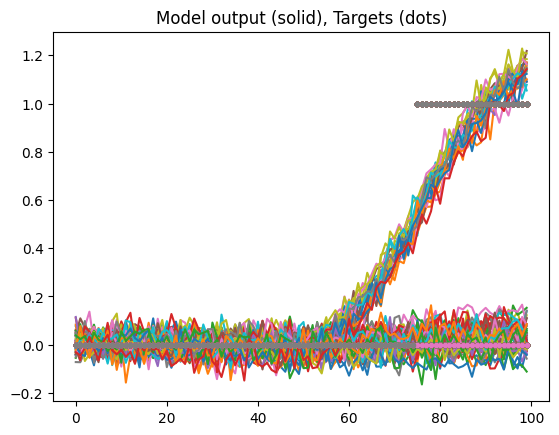

In [7]:
# plot the output of last batch (last group of trials)
# to visualize model performance
plt.plot(np.squeeze(outputs.detach().numpy()))
plt.plot(np.squeeze(targets.detach().numpy()),'.')
plt.title('Model output (solid), Targets (dots)')
plt.show()    

### Look at named model parameters to see current values of weights and biases and to see if they are trainable (requires_grad = True/False)

In [8]:
for p in net.named_parameters():
    print(p)

('recurrent_layer.inp_layer.weight', Parameter containing:
tensor([[-0.8035],
        [-0.7871],
        [ 0.4185],
        [-0.9800],
        [-1.0815],
        [-0.1675],
        [-0.8839],
        [-0.6974],
        [-0.6969],
        [ 0.6901],
        [-0.1620],
        [-0.7950],
        [ 0.9542],
        [-1.1873],
        [ 0.7920],
        [-0.7131],
        [-0.4859],
        [ 0.2387],
        [-0.6796],
        [-0.5221],
        [-0.2750],
        [ 0.8453],
        [-0.6479],
        [-1.1926],
        [ 0.1748],
        [-0.3603],
        [ 1.0626],
        [-0.6233],
        [-0.0857],
        [-0.3179],
        [ 1.2162],
        [ 0.5768],
        [-0.7484],
        [-0.8100],
        [-0.5648],
        [-0.9668],
        [-0.8156],
        [-0.2924],
        [-1.1306],
        [-1.5585],
        [ 1.0548],
        [ 0.7901],
        [-0.1178],
        [-1.0143],
        [-1.2138],
        [-0.5176],
        [-0.4841],
        [-0.3668],
        [ 0.0618],
        [-